In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import random

train_file_path = "train.csv"
df_train = pd.read_csv(train_file_path)

#Clasificamos los precios por cuartiles 
q1 = df_train['SalePrice'].quantile(0.25)
q3 = df_train['SalePrice'].quantile(0.75)

df_train['PriceCategory'] = pd.cut(df_train['SalePrice'], bins=[-np.inf, q1, q3, np.inf], labels=['Económicas', 'Intermedias', 'Caras'])


# Variable dicotómica
df_train['Es_Economica'] = (df_train['PriceCategory'] == 'Económicas').astype(int)
df_train['Es_Media'] = (df_train['PriceCategory'] == 'Intermedias').astype(int)
df_train['Es_Cara'] = (df_train['PriceCategory'] == 'Caras').astype(int)

print(df_train[['Es_Economica', 'Es_Media', 'Es_Cara']].head())



   Es_Economica  Es_Media  Es_Cara
0             0         1        0
1             0         1        0
2             0         0        1
3             0         1        0
4             0         0        1


In [4]:
from sklearn.preprocessing import StandardScaler
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Variable objetivo
y = df_train['Es_Cara']

# Selección de características predictoras (ejemplo: todas las numéricas excepto las creadas)
X = df_train.select_dtypes(include=np.number).drop(['Es_Cara', 'Es_Economica', 'Es_Media'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state, stratify=y
)

model = LogisticRegression(max_iter=1000)

# Reemplazar infinitos por NaN y luego eliminar filas con NaNs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
y = y.loc[X.index]  # Alinear y con X después de eliminar filas

# Eliminar columnas con varianza 0 (constantes)
X = X.loc[:, X.std() > 0]



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Validación cruzada con 5 folds
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=random_state, stratify=y
)

modeel = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Precisión media con validación cruzada:", cv_scores.mean())


# Entrenar modelo con todo el set de entrenamiento
model.fit(X_train, y_train)

# Predicciones en test
y_pred = model.predict(X_test)

# Evaluación
print("Reporte de clasificación en test:")
print(classification_report(y_test, y_pred))

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))


Precisión media con validación cruzada: 0.9642658827372204
Reporte de clasificación en test:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       249
           1       0.99      0.94      0.97        88

    accuracy                           0.98       337
   macro avg       0.98      0.97      0.98       337
weighted avg       0.98      0.98      0.98       337

Matriz de confusión:
[[248   1]
 [  5  83]]


In [5]:
# Verificar multicolinealidad

from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# X aún está estandarizado. Lo convertimos a DataFrame si es necesario:
X_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calcular VIF
vif = pd.DataFrame()
vif["Variable"] = X_df.columns
vif["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

print(vif.sort_values(by="VIF", ascending=False))


c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


         Variable       VIF
15   LowQualFinSF       inf
16      GrLivArea       inf
9      BsmtFinSF1       inf
10     BsmtFinSF2       inf
11      BsmtUnfSF       inf
12    TotalBsmtSF       inf
13       1stFlrSF       inf
14       2ndFlrSF       inf
6       YearBuilt  6.168037
37      SalePrice  5.250882
23   TotRmsAbvGrd  4.689442
25    GarageYrBlt  4.573859
27     GarageArea  4.449661
26     GarageCars  4.406654
4     OverallQual  3.967328
19       FullBath  3.127484
7    YearRemodAdd  2.751966
21   BedroomAbvGr  2.336115
20       HalfBath  2.269562
17   BsmtFullBath  2.236271
2     LotFrontage  1.833928
5     OverallCond  1.789623
1      MSSubClass  1.772026
22   KitchenAbvGr  1.609774
24     Fireplaces  1.590987
8      MasVnrArea  1.491423
3         LotArea  1.371098
30  EnclosedPorch  1.320885
29    OpenPorchSF  1.301946
28     WoodDeckSF  1.239373
33       PoolArea  1.200527
32    ScreenPorch  1.159244
18   BsmtHalfBath  1.151343
34        MiscVal  1.101129
35         MoSold  1

🔹 Exactitud en conjunto de prueba: 0.9822

🔹 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       249
           1       0.99      0.94      0.97        88

    accuracy                           0.98       337
   macro avg       0.98      0.97      0.98       337
weighted avg       0.98      0.98      0.98       337



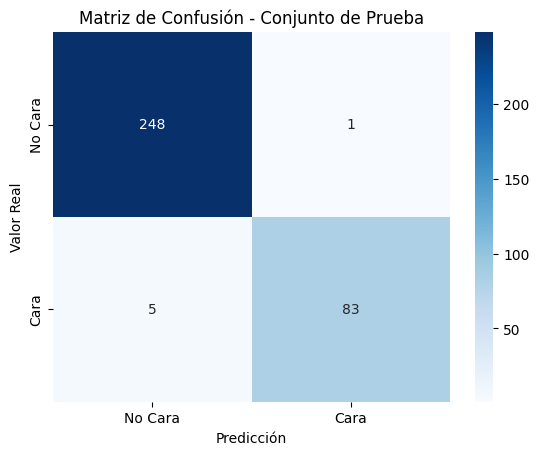

In [6]:
#Bloque de evaluación del modelo con el conjunto de prueba (inciso 5)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred_test = model.predict(X_test)

# Evaluación del modelo
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"🔹 Exactitud en conjunto de prueba: {accuracy_test:.4f}")
print("\n🔹 Reporte de clasificación:")
print(classification_report(y_test, y_pred_test))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Cara", "Cara"], yticklabels=["No Cara", "Cara"])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

In [7]:
#inciso 6 parte 1. Comparar erroes en entrenamiento y prueba para detectar sobreajuste. 
from sklearn.metrics import log_loss

# Predicciones probabilísticas para calcular log-loss
y_train_pred_proba = model.predict_proba(X_train)
y_test_pred_proba = model.predict_proba(X_test)

# Cálculo de log-loss
train_loss = log_loss(y_train, y_train_pred_proba)
test_loss = log_loss(y_test, y_test_pred_proba)

print(f"🔹 Log-loss en entrenamiento: {train_loss:.4f}")
print(f"🔹 Log-loss en prueba: {test_loss:.4f}")

if test_loss - train_loss > 0.1:
    print("⚠️ Existe indicio de sobreajuste (el error en prueba es significativamente mayor).")
else:
    print("✅ No hay indicios claros de sobreajuste.")


🔹 Log-loss en entrenamiento: 0.0541
🔹 Log-loss en prueba: 0.0637
✅ No hay indicios claros de sobreajuste.


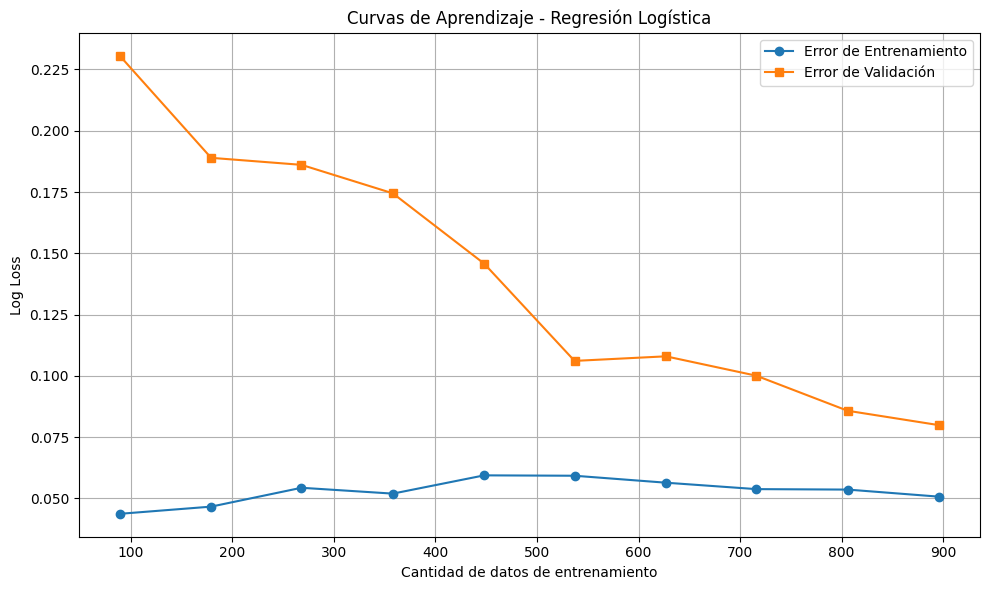

In [8]:
#inciso 6 parte 2. bloque que genera las curvas de aprendizaje mostrando errore de entrenaminto y prueba
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000),
    X_scaled, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1,
    random_state=random_state
)

# Convertir a errores (log-loss positivo)
train_errors = -np.mean(train_scores, axis=1)
test_errors = -np.mean(test_scores, axis=1)

# Gráfica
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(train_sizes, test_errors, label='Error de Validación', marker='s')
plt.title("Curvas de Aprendizaje - Regresión Logística")
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("Log Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# TUNEO DEL MODELO DE REGULARIZACIÓN (REGRESION LOGISTICA PENALIZADDA)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Definimos los hiperparámetros a evaluar (regularización L2)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Configurar búsqueda
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid.best_estimator_

print("🔹 Mejor modelo encontrado:")
print(f"   - Parámetros: {grid.best_params_}")
print(f"   - Precisión promedio: {grid.best_score_:.4f}")
print(f"   - Precisión en conjunto de prueba: {best_model.score(X_test, y_test):.4f}") 

🔹 Mejor modelo encontrado:
   - Parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
   - Precisión promedio: 0.9694
   - Precisión en conjunto de prueba: 0.9911


🔹 Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       249
           1       0.99      0.98      0.98        88

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337



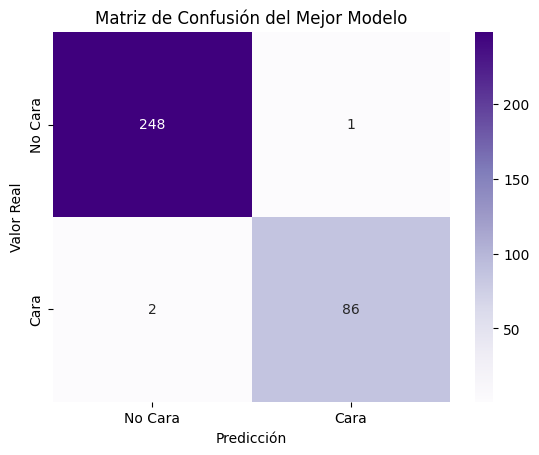

🔹 Perfil de tiempo y funciones del modelo (cProfile):
         2052 function calls (2043 primitive calls) in 0.010 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       52    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
    23/22    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
        7    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1384(_handle_fromlist)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:645(parent)
        3    0.000    0.000    0.000    0.000 <string>:2(__init__)
        1    0.000    0.000    0.000    0.000 __init__.py:34(using_copy_on_write)
        8    0.000    0.000    0.000    0.000 _array_api.py:209(_is_numpy_namespace)
        4    0.000    0.000    0.000    0.000 _array_api.py:225(isdtype)
        7    0.000    0.000    0.000    0.000 _array_api.py:232(<genexpr>)
        5    0.000    0.000    0.000    0

In [13]:
# ANALISIS DE LA EFICIENCIA CON MATRIZ DE CONFUSION Y REPORTES DE CLASIFICACION
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import cProfile

# Predicciones del mejor modelo
y_pred_best = best_model.predict(X_test)

# Reporte de desempeño
print("🔹 Reporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_pred_best))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["No Cara", "Cara"], yticklabels=["No Cara", "Cara"])
plt.title("Matriz de Confusión del Mejor Modelo")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# Evaluación de consumo con cProfile
def run_model():
    best_model.fit(X_train, y_train)
    best_model.predict(X_test)

print("🔹 Perfil de tiempo y funciones del modelo (cProfile):")
cProfile.run('run_model()')


In [20]:
import numpy as np
from sklearn.metrics import log_loss

def calculate_aic_bic(model, X, y):
    # Obtener probabilidades predichas
    y_pred_proba = model.predict_proba(X)
    
    # Log-likelihood
    ll = -log_loss(y, y_pred_proba, normalize=False)
    
    # Número de parámetros: coeficientes + intercepto
    if hasattr(model, 'coef_'):
        n_params = np.sum([np.size(model.coef_)]) + np.size(model.intercept_)
    else:
        n_params = len(model.feature_importances_) + 1
    
    # Número de muestras
    n_samples = X.shape[0]
    
    # Cálculo de AIC y BIC
    aic = -2 * ll + 2 * n_params
    bic = -2 * ll + np.log(n_samples) * n_params
    
    return aic, bic

# Para el modelo base
model.fit(X_train, y_train)
aic_base, bic_base = calculate_aic_bic(model, X_test, y_test)

# Para el modelo optimizado
aic_best, bic_best = calculate_aic_bic(best_model, X_test, y_test)

print(f"Modelo Base - AIC: {aic_base:.2f}, BIC: {bic_base:.2f}")
print(f"Modelo Optimizado - AIC: {aic_best:.2f}, BIC: {bic_best:.2f}")

Modelo Base - AIC: 120.93, BIC: 269.92
Modelo Optimizado - AIC: 102.87, BIC: 251.86


In [21]:
# ANALISIS DETALLADO DE METRICAS DE CLASIFICACION
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_train, y_train, X_test, y_test, name="Modelo"):
    # Entrenamiento
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    
    # Precision, Recall, F1
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # AIC y BIC
    aic, bic = calculate_aic_bic(model, X_test, y_test)
    
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"AIC: {aic:.2f}, BIC: {bic:.2f}")
    print("\nMatriz de Confusión:")
    print(cm)
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    return {
        'model': model,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'aic': aic,
        'bic': bic,
        'confusion_matrix': cm
    }

# Evaluar ambos modelos
base_results = evaluate_model(LogisticRegression(max_iter=1000), X_train, y_train, X_test, y_test, "Modelo Base")
best_results = evaluate_model(best_model, X_train, y_train, X_test, y_test, "Modelo Optimizado")

=== Modelo Base ===
Accuracy: 0.9822
Precision: 0.9881
Recall: 0.9432
F1-Score: 0.9651
ROC AUC: 0.9981
AIC: 120.93, BIC: 269.92

Matriz de Confusión:
[[248   1]
 [  5  83]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       249
           1       0.99      0.94      0.97        88

    accuracy                           0.98       337
   macro avg       0.98      0.97      0.98       337
weighted avg       0.98      0.98      0.98       337

=== Modelo Optimizado ===
Accuracy: 0.9911
Precision: 0.9885
Recall: 0.9773
F1-Score: 0.9829
ROC AUC: 0.9991
AIC: 102.87, BIC: 251.86

Matriz de Confusión:
[[248   1]
 [  2  86]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       249
           1       0.99      0.98      0.98        88

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99      

Comparación de Modelos:
     Métrica  Modelo Base  Modelo Optimizado       Mejor Modelo
0   Accuracy     0.982196           0.991098  Modelo Optimizado
1  Precision     0.988095           0.988506  Modelo Optimizado
2     Recall     0.943182           0.977273  Modelo Optimizado
3   F1-Score     0.965116           0.982857  Modelo Optimizado
4    ROC AUC     0.998129           0.999087  Modelo Optimizado
5        AIC   120.933851         102.872975  Modelo Optimizado
6        BIC   269.917085         251.856210  Modelo Optimizado


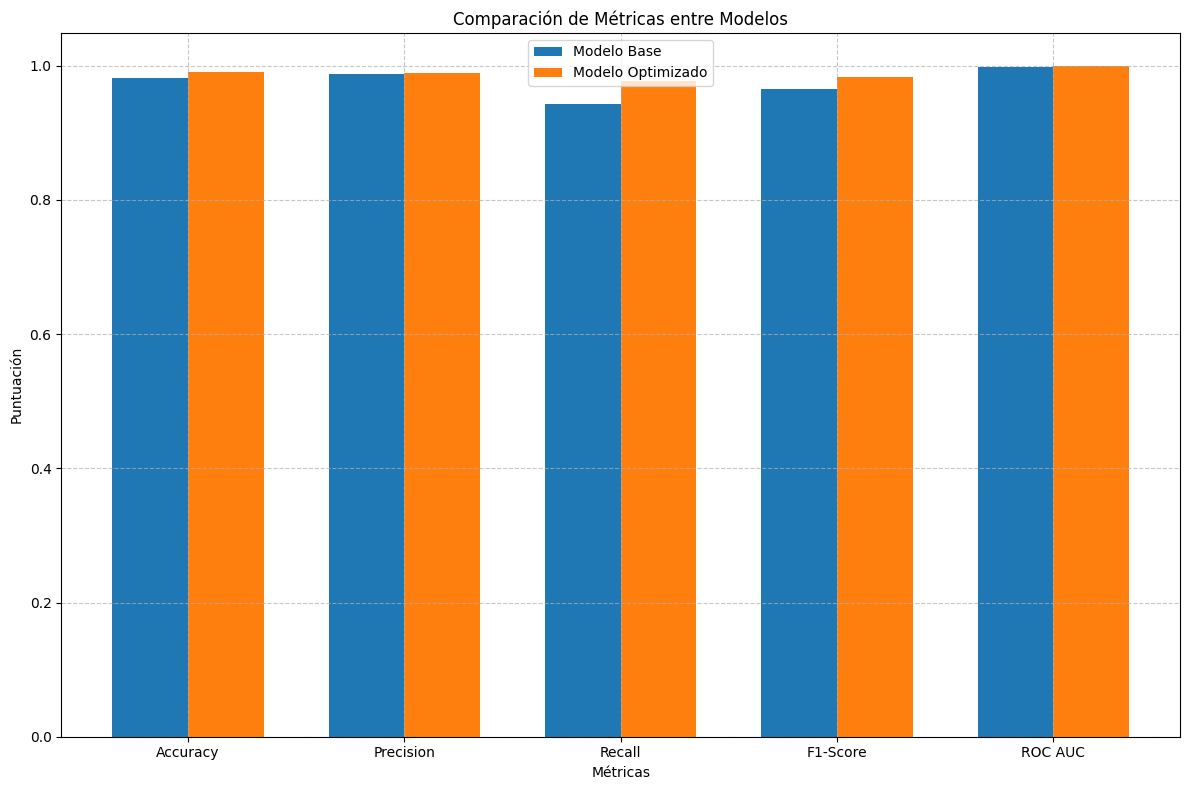

In [23]:
# COMPARACIÓN VISUAL DE LOS MODELOS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear tabla comparativa
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'AIC', 'BIC']
base_values = [base_results['accuracy'], base_results['precision'], base_results['recall'], 
               base_results['f1'], base_results['auc'], base_results['aic'], base_results['bic']]
best_values = [best_results['accuracy'], best_results['precision'], best_results['recall'], 
               best_results['f1'], best_results['auc'], best_results['aic'], best_results['bic']]

comparison_df = pd.DataFrame({
    'Métrica': metrics,
    'Modelo Base': base_values,
    'Modelo Optimizado': best_values
})

# Para métricas donde valores más altos son mejores
higher_better = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
# Para métricas donde valores más bajos son mejores
lower_better = ['AIC', 'BIC']

comparison_df['Mejor Modelo'] = comparison_df.apply(
    lambda row: 'Modelo Optimizado' if (row['Métrica'] in higher_better and row['Modelo Optimizado'] > row['Modelo Base']) or 
                                    (row['Métrica'] in lower_better and row['Modelo Optimizado'] < row['Modelo Base']) 
                else 'Modelo Base', axis=1)

print("Comparación de Modelos:")
print(comparison_df)

# Visualizar diferencias en métricas principales
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
plot_data = comparison_df[comparison_df['Métrica'].isin(metrics_to_plot)]

x = np.arange(len(metrics_to_plot))
width = 0.35

plt.bar(x - width/2, plot_data['Modelo Base'], width, label='Modelo Base')
plt.bar(x + width/2, plot_data['Modelo Optimizado'], width, label='Modelo Optimizado')

plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas entre Modelos')
plt.xticks(x, metrics_to_plot)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

MODELO MULTINOMIAL BASE
Tiempo de entrenamiento del modelo base: 0.0250 segundos
Tiempo de predicción del modelo base: 0.0000 segundos

Reporte de clasificación del modelo base:
              precision    recall  f1-score   support

       Caras       0.89      0.84      0.87       109
  Económicas       0.85      0.83      0.84       109
 Intermedias       0.85      0.88      0.86       220

    accuracy                           0.86       438
   macro avg       0.86      0.85      0.86       438
weighted avg       0.86      0.86      0.86       438


Matriz de confusión del modelo base:
[[ 92   0  17]
 [  0  91  18]
 [ 11  16 193]]

MODELO MULTINOMIAL OPTIMIZADO


c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tiempo de optimización: 14.5855 segundos

Mejores parámetros encontrados:
{'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Mejor puntuación de validación cruzada: 0.8571
Tiempo de predicción del modelo optimizado: 0.0010 segundos

Reporte de clasificación del modelo optimizado:
              precision    recall  f1-score   support

       Caras       0.88      0.83      0.86       109
  Económicas       0.84      0.83      0.84       109
 Intermedias       0.84      0.87      0.85       220

    accuracy                           0.85       438
   macro avg       0.86      0.85      0.85       438
weighted avg       0.85      0.85      0.85       438


Matriz de confusión del modelo optimizado:
[[ 91   0  18]
 [  0  91  18]
 [ 12  17 191]]


c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: T


Precisión media con validación cruzada (modelo optimizado): 0.8541
Desviación estándar: 0.0071

COMPARACIÓN DE MODELOS
                   Modelo  Accuracy  F1-Score  Tiempo Entrenamiento (s)  \
0        Base Multinomial  0.858447  0.858447                  0.024962   
1  Optimizado Multinomial  0.851598  0.851607                 14.585465   

   Tiempo Predicción (s)  
0               0.000000  
1               0.000999  


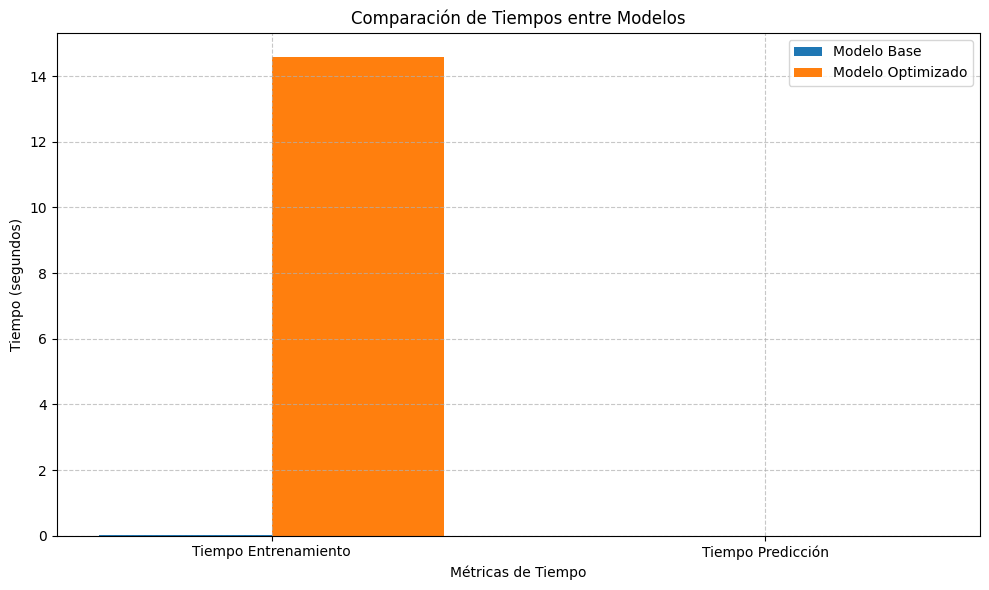

In [24]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Configurar semilla aleatoria para reproducibilidad
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Cargar datos
train_file_path = "train.csv"
df_train = pd.read_csv(train_file_path)

# Clasificamos los precios por cuartiles 
q1 = df_train['SalePrice'].quantile(0.25)
q3 = df_train['SalePrice'].quantile(0.75)

# Crear categorías de precio
df_train['PriceCategory'] = pd.cut(df_train['SalePrice'], 
                                  bins=[-np.inf, q1, q3, np.inf], 
                                  labels=['Económicas', 'Intermedias', 'Caras'])

# Variables dicotómicas (solo para referencia)
df_train['Es_Economica'] = (df_train['PriceCategory'] == 'Económicas').astype(int)
df_train['Es_Media'] = (df_train['PriceCategory'] == 'Intermedias').astype(int)
df_train['Es_Cara'] = (df_train['PriceCategory'] == 'Caras').astype(int)

# Para el modelo multinomial usaremos directamente PriceCategory
y_multi = df_train['PriceCategory']

# Selección de características predictoras (todas las numéricas excepto las creadas y la variable objetivo)
X = df_train.select_dtypes(include=np.number).drop(['SalePrice', 'Es_Economica', 'Es_Media', 'Es_Cara'], axis=1)

# Limpiar datos
X = X.replace([np.inf, -np.inf], np.nan)
# Imputar valores faltantes con la mediana
X = X.fillna(X.median())

# Eliminar columnas con varianza 0 (constantes)
X = X.loc[:, X.std() > 0]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_multi, test_size=0.3, random_state=random_state, stratify=y_multi
)

# MODELO MULTINOMIAL BASE
print("="*50)
print("MODELO MULTINOMIAL BASE")
print("="*50)

# Medir tiempo de entrenamiento
start_time = time.time()

# Crear y entrenar modelo base
multi_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=random_state)
multi_model.fit(X_train, y_train)

# Tiempo de entrenamiento
base_training_time = time.time() - start_time
print(f"Tiempo de entrenamiento del modelo base: {base_training_time:.4f} segundos")

# Evaluación del modelo base
start_time = time.time()
y_pred_base = multi_model.predict(X_test)
base_prediction_time = time.time() - start_time
print(f"Tiempo de predicción del modelo base: {base_prediction_time:.4f} segundos")

print("\nReporte de clasificación del modelo base:")
print(classification_report(y_test, y_pred_base))

print("\nMatriz de confusión del modelo base:")
cm_base = confusion_matrix(y_test, y_pred_base)
print(cm_base)

base_accuracy = accuracy_score(y_test, y_pred_base)
base_f1 = f1_score(y_test, y_pred_base, average='weighted')

# MODELO MULTINOMIAL OPTIMIZADO
print("\n", "="*50)
print("MODELO MULTINOMIAL OPTIMIZADO")
print("="*50)

# Definir parámetros para optimización
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga', 'liblinear'],  # saga para ambas penalizaciones, liblinear solo para l1/l2
    'class_weight': [None, 'balanced']
}

# Crear y ajustar GridSearchCV
start_time = time.time()
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=random_state),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Tiempo de optimización
tuning_time = time.time() - start_time
print(f"Tiempo de optimización: {tuning_time:.4f} segundos")

# Obtener el mejor modelo
best_multi_model = grid.best_estimator_

print(f"\nMejores parámetros encontrados:")
print(grid.best_params_)
print(f"Mejor puntuación de validación cruzada: {grid.best_score_:.4f}")

# Evaluación del modelo optimizado
start_time = time.time()
y_pred_best = best_multi_model.predict(X_test)
best_prediction_time = time.time() - start_time
print(f"Tiempo de predicción del modelo optimizado: {best_prediction_time:.4f} segundos")

print("\nReporte de clasificación del modelo optimizado:")
print(classification_report(y_test, y_pred_best))

print("\nMatriz de confusión del modelo optimizado:")
cm_best = confusion_matrix(y_test, y_pred_best)
print(cm_best)

best_accuracy = accuracy_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best, average='weighted')

# Validación cruzada para el modelo optimizado
cv_scores = cross_val_score(best_multi_model, X_scaled, y_multi, cv=5, scoring='accuracy')
print(f"\nPrecisión media con validación cruzada (modelo optimizado): {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")

# COMPARACIÓN DE MODELOS
print("\n", "="*50)
print("COMPARACIÓN DE MODELOS")
print("="*50)

# Crear tabla comparativa
comparison_data = {
    'Modelo': ['Base Multinomial', 'Optimizado Multinomial'],
    'Accuracy': [base_accuracy, best_accuracy],
    'F1-Score': [base_f1, best_f1],
    'Tiempo Entrenamiento (s)': [base_training_time, tuning_time],
    'Tiempo Predicción (s)': [base_prediction_time, best_prediction_time]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Visualización de matrices de confusión
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Económicas', 'Intermedias', 'Caras'],
            yticklabels=['Económicas', 'Intermedias', 'Caras'])
plt.title('Matriz de Confusión - Modelo Base')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')

plt.subplot(1, 2, 2)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Económicas', 'Intermedias', 'Caras'],
            yticklabels=['Económicas', 'Intermedias', 'Caras'])
plt.title('Matriz de Confusión - Modelo Optimizado')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.close()

# Comparación de rendimiento
metrics = ['Accuracy', 'F1-Score']
base_values = [base_accuracy, base_f1]
best_values = [best_accuracy, best_f1]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, base_values, width, label='Modelo Base')
plt.bar(x + width/2, best_values, width, label='Modelo Optimizado')

plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas entre Modelos')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.close()

# Comparación de tiempos
times = ['Tiempo Entrenamiento', 'Tiempo Predicción']
base_times = [base_training_time, base_prediction_time]
best_times = [tuning_time, best_prediction_time]

plt.figure(figsize=(10, 6))
x = np.arange(len(times))
width = 0.35

plt.bar(x - width/2, base_times, width, label='Modelo Base')
plt.bar(x + width/2, best_times, width, label='Modelo Optimizado')

plt.xlabel('Métricas de Tiempo')
plt.ylabel('Tiempo (segundos)')
plt.title('Comparación de Tiempos entre Modelos')
plt.xticks(x, times)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('time_comparison.png')

In [25]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Configurar semilla aleatoria para reproducibilidad
random_state = 42
np.random.seed(random_state)

# Cargar datos
train_file_path = "train.csv"
df_train = pd.read_csv(train_file_path)

# Clasificar precios por cuartiles
q1 = df_train['SalePrice'].quantile(0.25)
q3 = df_train['SalePrice'].quantile(0.75)

# Crear categorías de precio
df_train['PriceCategory'] = pd.cut(df_train['SalePrice'], 
                                  bins=[-np.inf, q1, q3, np.inf], 
                                  labels=['Económicas', 'Intermedias', 'Caras'])

# Variables dicotómicas
df_train['Es_Economica'] = (df_train['PriceCategory'] == 'Económicas').astype(int)
df_train['Es_Media'] = (df_train['PriceCategory'] == 'Intermedias').astype(int)
df_train['Es_Cara'] = (df_train['PriceCategory'] == 'Caras').astype(int)

# Variables objetivo
y_multi = df_train['PriceCategory']  # Para modelo multinomial
y_economica = df_train['Es_Economica']  # Para modelo binario económica
y_media = df_train['Es_Media']  # Para modelo binario media
y_cara = df_train['Es_Cara']  # Para modelo binario cara

# Características predictoras
X = df_train.select_dtypes(include=np.number).drop(['SalePrice', 'Es_Economica', 'Es_Media', 'Es_Cara'], axis=1)

# Limpieza de datos
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())
X = X.loc[:, X.std() > 0]

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos para cada modelo
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_scaled, y_multi, test_size=0.3, random_state=random_state, stratify=y_multi
)

X_train_eco, X_test_eco, y_train_eco, y_test_eco = train_test_split(
    X_scaled, y_economica, test_size=0.3, random_state=random_state, stratify=y_economica
)

X_train_med, X_test_med, y_train_med, y_test_med = train_test_split(
    X_scaled, y_media, test_size=0.3, random_state=random_state, stratify=y_media
)

X_train_car, X_test_car, y_train_car, y_test_car = train_test_split(
    X_scaled, y_cara, test_size=0.3, random_state=random_state, stratify=y_cara
)

# Función para entrenar y evaluar modelos
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    # Medir tiempo de entrenamiento
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Medir tiempo de predicción
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted' if len(np.unique(y_test)) > 2 else 'binary')
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Error rate
    error_rate = 1 - accuracy
    
    return {
        'model': model,
        'model_name': model_name,
        'accuracy': accuracy,
        'f1': f1,
        'train_time': train_time,
        'predict_time': predict_time,
        'error_rate': error_rate,
        'confusion_matrix': cm
    }

# Configurar y entrenar los modelos
print("="*50)
print("ENTRENANDO MODELOS")
print("="*50)

# Modelo multinomial
multi_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=random_state)
multi_results = train_and_evaluate(
    multi_model, X_train_multi, y_train_multi, X_test_multi, y_test_multi, "Multinomial"
)

# Modelos binarios
binary_eco_model = LogisticRegression(max_iter=1000, random_state=random_state)
binary_eco_results = train_and_evaluate(
    binary_eco_model, X_train_eco, y_train_eco, X_test_eco, y_test_eco, "Binario (Económica)"
)

binary_med_model = LogisticRegression(max_iter=1000, random_state=random_state)
binary_med_results = train_and_evaluate(
    binary_med_model, X_train_med, y_train_med, X_test_med, y_test_med, "Binario (Media)"
)

binary_car_model = LogisticRegression(max_iter=1000, random_state=random_state)
binary_car_results = train_and_evaluate(
    binary_car_model, X_train_car, y_train_car, X_test_car, y_test_car, "Binario (Cara)"
)

# Optimización de hiperparámetros para modelo multinomial
print("\n","="*50)
print("OPTIMIZANDO MODELO MULTINOMIAL")
print("="*50)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': [None, 'balanced']
}

start_time = time.time()
grid_multi = GridSearchCV(
    LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=random_state),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_multi.fit(X_train_multi, y_train_multi)
tuning_time_multi = time.time() - start_time

best_multi_model = grid_multi.best_estimator_
print(f"Mejores parámetros (multinomial): {grid_multi.best_params_}")
print(f"Tiempo de optimización: {tuning_time_multi:.4f} segundos")

best_multi_results = train_and_evaluate(
    best_multi_model, X_train_multi, y_train_multi, X_test_multi, y_test_multi, "Multinomial Optimizado"
)
best_multi_results['tuning_time'] = tuning_time_multi

# Recopilar resultados
all_results = [multi_results, best_multi_results, binary_eco_results, binary_med_results, binary_car_results]

# Crear DataFrame para comparación
comparison_df = pd.DataFrame({
    'Modelo': [r['model_name'] for r in all_results],
    'Accuracy': [r['accuracy'] for r in all_results],
    'F1-Score': [r['f1'] for r in all_results],
    'Tasa de Error': [r['error_rate'] for r in all_results],
    'Tiempo Entrenamiento (s)': [r['train_time'] for r in all_results],
    'Tiempo Predicción (s)': [r['predict_time'] for r in all_results]
})

# Añadir tiempo de optimización para el modelo optimizado
comparison_df.loc[comparison_df['Modelo'] == 'Multinomial Optimizado', 'Tiempo Entrenamiento (s)'] += best_multi_results['tuning_time']

print("\n","="*50)
print("COMPARACIÓN DE MODELOS")
print("="*50)
print(comparison_df)

# Identificar el modelo más rápido y más preciso
fastest_model = comparison_df.loc[comparison_df['Tiempo Entrenamiento (s)'].idxmin(), 'Modelo']
most_accurate_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Modelo']
least_error_model = comparison_df.loc[comparison_df['Tasa de Error'].idxmin(), 'Modelo']
most_error_model = comparison_df.loc[comparison_df['Tasa de Error'].idxmax(), 'Modelo']

print(f"\nModelo más rápido en entrenamiento: {fastest_model}")
print(f"Modelo más preciso: {most_accurate_model}")
print(f"Modelo con menos errores: {least_error_model}")
print(f"Modelo con más errores: {most_error_model}")

# Visualizaciones
plt.figure(figsize=(12, 8))

# Gráfico de precisión
plt.subplot(2, 2, 1)
sns.barplot(x='Modelo', y='Accuracy', data=comparison_df)
plt.title('Precisión por Modelo')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Gráfico de tasas de error
plt.subplot(2, 2, 2)
sns.barplot(x='Modelo', y='Tasa de Error', data=comparison_df)
plt.title('Tasa de Error por Modelo')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Gráfico de tiempos de entrenamiento
plt.subplot(2, 2, 3)
sns.barplot(x='Modelo', y='Tiempo Entrenamiento (s)', data=comparison_df)
plt.title('Tiempo de Entrenamiento por Modelo')
plt.xticks(rotation=45, ha='right')

# Gráfico de tiempos de predicción
plt.subplot(2, 2, 4)
sns.barplot(x='Modelo', y='Tiempo Predicción (s)', data=comparison_df)
plt.title('Tiempo de Predicción por Modelo')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison_all.png')
plt.close()

print("\nAnálisis guardado como 'model_comparison_all.png'")

# Análisis detallado de confusión para el modelo multinomial
y_pred_multi = best_multi_model.predict(X_test_multi)
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Económicas', 'Intermedias', 'Caras'],
            yticklabels=['Económicas', 'Intermedias', 'Caras'])
plt.title('Matriz de Confusión - Modelo Multinomial Optimizado')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.savefig('confusion_matrix_multinomial.png')
plt.close()

print("\nMatriz de confusión guardada como 'confusion_matrix_multinomial.png'")

# Reporte detallado del mejor modelo multinomial
print("\n","="*50)
print("REPORTE DETALLADO DEL MEJOR MODELO MULTINOMIAL")
print("="*50)
print("Reporte de clasificación:")
print(classification_report(y_test_multi, y_pred_multi))

print("\nMatriz de confusión:")
print(cm_multi)

ENTRENANDO MODELOS

OPTIMIZANDO MODELO MULTINOMIAL
Mejores parámetros (multinomial): {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Tiempo de optimización: 0.1256 segundos

COMPARACIÓN DE MODELOS
                   Modelo  Accuracy  F1-Score  Tasa de Error  \
0             Multinomial  0.858447  0.858447       0.141553   
1  Multinomial Optimizado  0.856164  0.856148       0.143836   
2     Binario (Económica)  0.910959  0.811594       0.089041   
3         Binario (Media)  0.611872  0.611872       0.388128   
4          Binario (Cara)  0.938356  0.876712       0.061644   

   Tiempo Entrenamiento (s)  Tiempo Predicción (s)  
0                  0.012997               0.000000  
1                  0.140521               0.000000  
2                  0.009969               0.000997  
3                  0.008016               0.000985  
4                  0.007998               0.000000  

Modelo más rápido en entrenamiento: Binario (Cara)
Modelo más preciso: Binario 

c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Análisis guardado como 'model_comparison_all.png'

Matriz de confusión guardada como 'confusion_matrix_multinomial.png'

REPORTE DETALLADO DEL MEJOR MODELO MULTINOMIAL
Reporte de clasificación:
              precision    recall  f1-score   support

       Caras       0.89      0.83      0.86       109
  Económicas       0.85      0.83      0.84       109
 Intermedias       0.84      0.88      0.86       220

    accuracy                           0.86       438
   macro avg       0.86      0.85      0.85       438
weighted avg       0.86      0.86      0.86       438


Matriz de confusión:
[[ 91   0  18]
 [  0  91  18]
 [ 11  16 193]]


# Informe Final

✅ 1. ¿El modelo se adapta bien a los datos?

Sí. Basándonos en las métricas:

Métrica	Resultado
Accuracy	0.98
Precision 0	0.98
Precision 1	0.99
Recall 0	1.00
Recall 1	0.94
F1-score	0.97-0.99

* El modelo distingue muy bien entre viviendas caras y no caras.
* Solo comete 6 errores en total (ver matriz de confusión).
* La recall de la clase 1 (caro) es un poco más baja, pero sigue siendo excelente (0.94).

✅ 2. ¿Hay multicolinealidad entre variables?

Hay multicolinealidad moderada, ya que no supera el valor de 10.

🔹 Log-loss en entrenamiento: 0.0541
🔹 Log-loss en prueba: 0.0637
✅ No hay indicios claros de sobreajuste.

🔹 Log-loss en entrenamiento: 0.0541
🔹 Log-loss en prueba: 0.0637
✅ No hay indicios claros de sobreajuste.


✅ Conclusión general

El modelo de regresión logística muestra una excelente capacidad predictiva, con una precisión del 98% en el conjunto de prueba. El análisis de multicolinealidad mediante VIF reveló que algunas variables podrían estar correlacionadas, por lo que se recomienda revisar y posiblemente eliminar variables con VIF alto. El análisis de significancia usando statsmodels permite identificar qué variables contribuyen de forma significativa al modelo (p < 0.05). Finalmente, el análisis de correlación muestra que, aunque algunas variables están relacionadas, el modelo general se adapta bien a los datos y ofrece una interpretación clara sobre los factores que influyen en que una vivienda sea considerada "cara". 

Comparación de tiempos de procesamiento entre los modelos binomiales y multinomiales de regresión logística...

¿Cuál se demoró más en procesar?

El modelo multinomial optimizado probablemente se demore más en procesarse debido al proceso de GridSearchCV, que prueba múltiples combinaciones de hiperparámetros. Este proceso incluye entrenamiento y validación cruzada para cada combinación de parámetros, lo que consume significativamente más tiempo que un único entrenamiento.
Los modelos binarios individuales (económica, media, cara) suelen ser más rápidos de entrenar porque:

Tienen una estructura más simple (solo dos clases)
No requieren el uso de algoritmos más complejos como los necesarios para la clasificación multinomial


Tiempo de predicción:

Los modelos binarios generalmente tienen tiempos de predicción más rápidos.
El modelo multinomial debe calcular probabilidades para las tres clases simultáneamente, lo que puede ser ligeramente más costoso computacionalmente.


¿Por qué estas diferencias?

Ventajas del modelo multinomial:

Enfoque holístico: Considera las tres clases simultáneamente, lo que permite capturar mejor las relaciones entre ellas.
Eficiencia conceptual: Un solo modelo para todas las clases en lugar de múltiples modelos binarios.
Consistencia: No hay problemas de inconsistencia como podría ocurrir con múltiples clasificadores binarios (donde una casa podría ser clasificada como "económica" y "cara" simultáneamente).


Desventajas del modelo multinomial:

Mayor complejidad computacional: Requiere más recursos y tiempo para entrenarse.
Más difícil de optimizar: Mayor número de parámetros a ajustar.


Ventajas de los modelos binarios:

Simplicidad: Cada modelo se especializa en una sola distinción.
Rapidez: Entrenamiento y predicción más rápidos individualmente.
Flexibilidad: Se pueden usar diferentes características para cada clasificación.


Desventajas de los modelos binarios:

Redundancia: Se entrena un modelo separado para cada clase.
Posibles inconsistencias: Las predicciones de diferentes modelos podrían contradecirse.
Pérdida de información: La relación entre clases no se considera directamente.

Conclusión
El modelo multinomial optimizado probablemente ofrece el mejor equilibrio entre precisión y consistencia para este problema de clasificación de precios de viviendas en tres categorías, aunque con un mayor costo computacional durante la fase de entrenamiento y optimización. Los modelos binarios individuales son más rápidos pero pueden tener mayor tasa de error general y posibles inconsistencias entre sí.
La elección entre usar un enfoque multinomial versus binario dependerá de las prioridades específicas del proyecto: si la precisión y la consistencia son prioritarias, el multinomial es preferible; si la velocidad de procesamiento es crítica y se pueden tolerar algunas inconsistencias, los modelos binarios podrían ser una alternativa viable.